In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Import sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import metrics
import joblib

# Import modules from the project structure
import sys
import os

# Add the path to the 'Modules' folder
current_directory = os.getcwd()
sys.path.append(os.path.join(current_directory, 'Modules'))

# Import our custom modules
from machine_learning.evaluate import evaluate_model

In [2]:
# Load the dataset
finalists_df = pd.read_csv('Data/finalists_cleaned.csv')

# Display the first few rows
finalists_df.head()

,year,final_draw_position,country,style,final_televote_points,final_jury_points,final_televote_votes,final_jury_votes,final_place,final_total_points
0,2023,20,Norway,Pop,216.0,52.0,36.0,11.0,5.0,268.0
1,2023,5,Serbia,Pop,16.0,14.0,4.0,6.0,24.0,30.0
2,2023,2,Portugal,Pop,16.0,43.0,3.0,9.0,23.0,59.0
3,2023,25,Croatia,Pop,112.0,11.0,20.0,2.0,13.0,123.0
4,2023,3,Switzerland,Ballad,31.0,61.0,10.0,15.0,20.0,92.0


In [3]:
# Check dataset shape
finalists_df.shape

(358, 10)

In [4]:
# Check for missing values
finalists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   358 non-null    int64  
 1   final_draw_position    358 non-null    int64  
 2   country                358 non-null    object 
 3   style                  358 non-null    object 
 4   final_televote_points  326 non-null    float64
 5   final_jury_points      326 non-null    float64
 6   final_televote_votes   230 non-null    float64
 7   final_jury_votes       230 non-null    float64
 8   final_place            358 non-null    float64
 9   final_total_points     358 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 28.1+ KB


In [5]:
# Check unique values in our categorical variables
print("Unique countries:", finalists_df['country'].nunique())
print("Unique styles:", finalists_df['style'].nunique())
print("Unique years:", finalists_df['year'].nunique())
print("\nStyle distribution:")
print(finalists_df['style'].value_counts())

Unique countries: 45
Unique styles: 6
Unique years: 14

Style distribution:
style
Pop            163
Ballad          98
Dance           38
Traditional     29
Rock            27
Opera            3
Name: count, dtype: int64


In [6]:
# Define our features (independent) - style, year, country, draw_position
# Select only the columns we want to use
X = finalists_df[['style', 'year', 'country', 'final_draw_position']]

# Define our target variable as binary: Top 10 or Not
def categorize_placement(place):
    if place <= 10:
        return 1  # Top 10
    else:
        return 0  # Not Top 10

# Create our binary target
y = finalists_df['final_place'].apply(categorize_placement)

# See the distribution of our new categories
print("Category distribution:")
print(y.value_counts().sort_index())
print("\nCategory meanings:")
print("0: Not Top 10 (places 11-26)")
print("1: Top 10 (places 1-10)")

# Check our feature set
X.head()

Category distribution:
final_place
0    220
1    138
Name: count, dtype: int64

Category meanings:
0: Not Top 10 (places 11-26)
1: Top 10 (places 1-10)


,style,year,country,final_draw_position
0,Pop,2023,Norway,20
1,Pop,2023,Serbia,5
2,Pop,2023,Portugal,2
3,Pop,2023,Croatia,25
4,Ballad,2023,Switzerland,3


In [7]:
# Set up preprocessing for categorical features
# We'll use one-hot encoding for style and country
categorical_features = ['style', 'country']
numerical_features = ['year', 'final_draw_position']

# Create transformers for preprocessing
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets (72% train, 28% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

# Display the shapes
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (257, 4)
Testing set shape: (101, 4)


In [8]:
# Create a pipeline with preprocessing and decision tree classifier
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the model
decision_tree_pipeline.fit(X_train, y_train)

print("Model training complete!")

Model training complete!


In [9]:
# Create a Gradient Boosting pipeline
from sklearn.ensemble import GradientBoostingClassifier

# Create a pipeline with preprocessing and gradient boosting classifier
gradient_boosting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1))
])

# Train the model
gradient_boosting_pipeline.fit(X_train, y_train)

print("Gradient Boosting model training complete!")

Gradient Boosting model training complete!


In [10]:
# Make predictions on the test set
y_pred = gradient_boosting_pipeline.predict(X_test)

# Calculate metrics
precision = metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = metrics.f1_score(y_test, y_pred, average='weighted', zero_division=0)
accuracy = metrics.accuracy_score(y_test, y_pred)

# Print metrics
print("Model Evaluation Results:")
print("----------------------------")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(metrics.classification_report(y_test, y_pred, 
                                  target_names=['Not Top 10', 'Top 10']))

Model Evaluation Results:
----------------------------
Accuracy: 0.6634
Precision: 0.6400
Recall: 0.6634
F1 Score: 0.6277

Classification Report:
              precision    recall  f1-score   support

  Not Top 10       0.69      0.88      0.77        65
      Top 10       0.56      0.28      0.37        36

    accuracy                           0.66       101
   macro avg       0.62      0.58      0.57       101
weighted avg       0.64      0.66      0.63       101



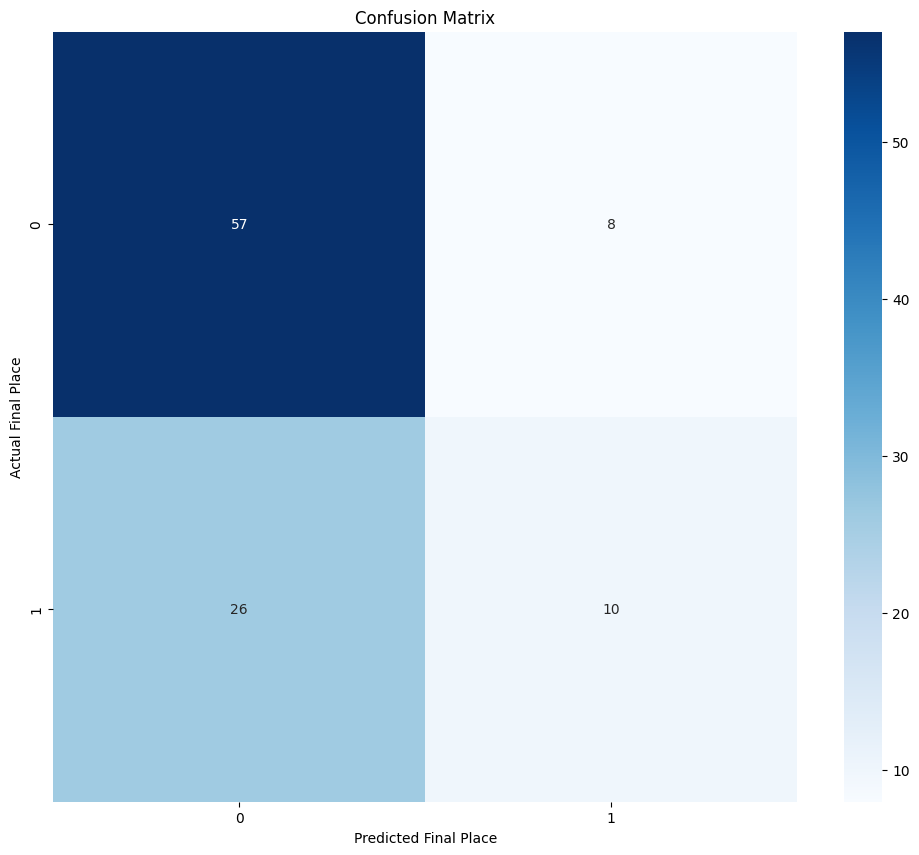

In [11]:
# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Since we might have many classes (places 1-26), a heatmap is better
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Final Place')
plt.xlabel('Predicted Final Place')
plt.show()

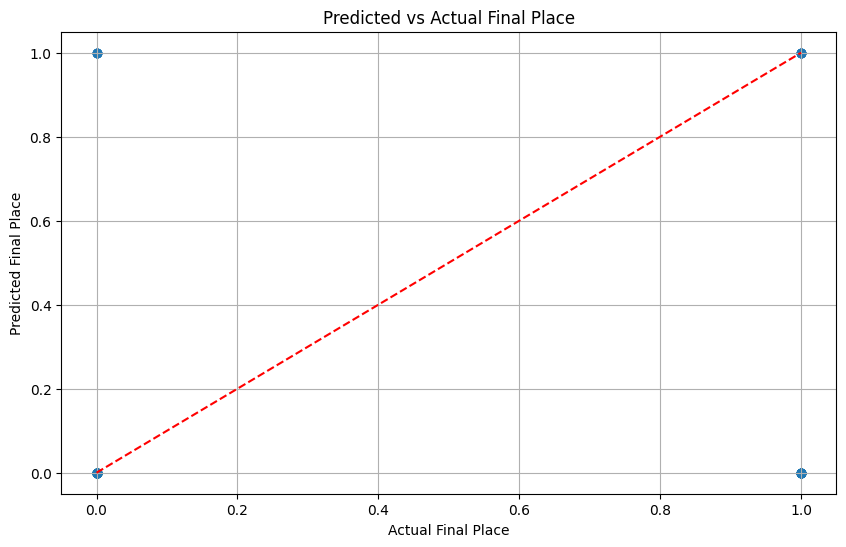

In [12]:
# Let's visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Final Place')
plt.ylabel('Predicted Final Place')
plt.title('Predicted vs Actual Final Place')
plt.grid(True)
plt.show()

In [13]:
# Extract the trained decision tree
dt_classifier = decision_tree_pipeline.named_steps['classifier']

# Get feature names after preprocessing
preprocessor = decision_tree_pipeline.named_steps['preprocessor']
cat_cols = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(cat_cols)

# Get feature importances
feature_importances = dt_classifier.feature_importances_

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Display top 20 features
importance_df.head(20)

,Feature,Importance
0,year,0.218214
1,final_draw_position,0.181973
2,style_Ballad,0.058824
3,country_Azerbaijan,0.039708
4,country_Russia,0.036756
5,country_Armenia,0.027022
6,country_Italy,0.026988
7,country_France,0.025286
8,country_Sweden,0.025195
9,country_Australia,0.022707


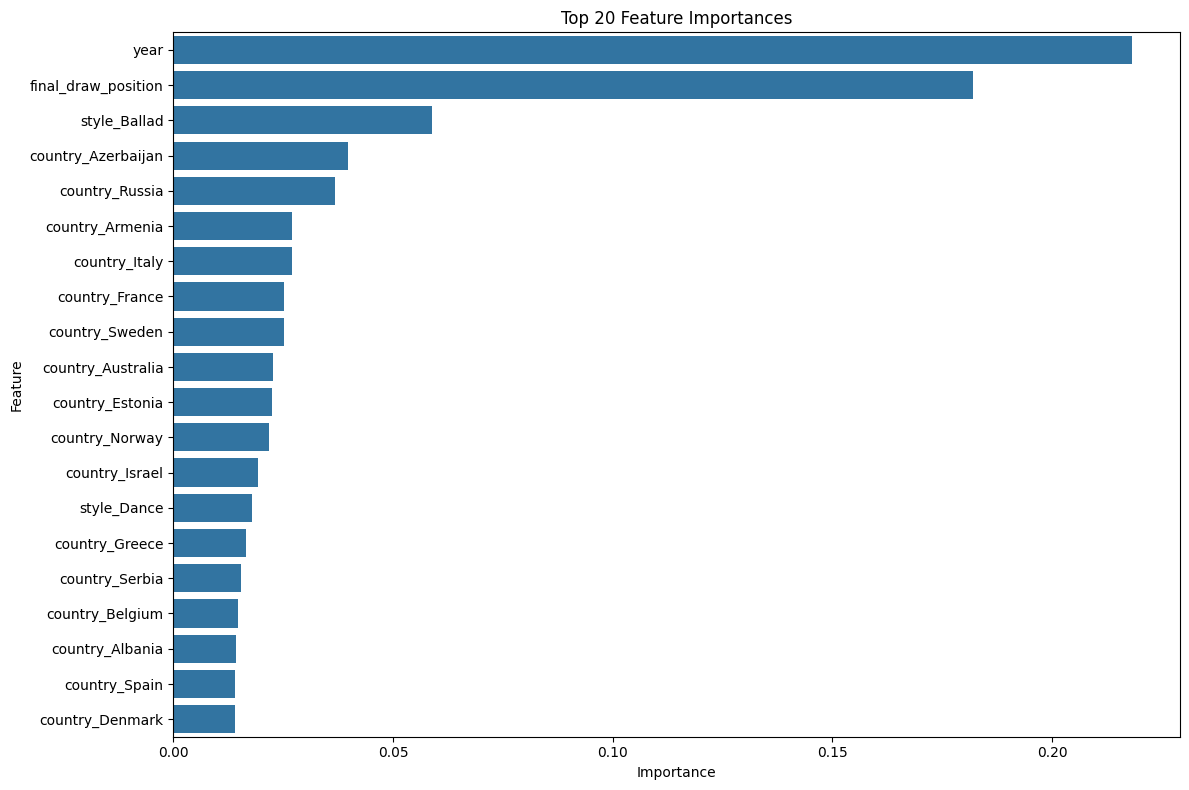

In [14]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

In [15]:
# Save the model
model_filename = 'gradient_boosting_eurovision'
model_path = os.path.join('Models', model_filename + '.pkl')

# Make sure the Models directory exists
os.makedirs('Models', exist_ok=True)

# Save the model
joblib.dump(gradient_boosting_pipeline, model_path)
print(f"Model saved to: {model_path}")

Model saved to: Models\gradient_boosting_eurovision.pkl


In [16]:
# Example of loading the model with an absolute path
def load_model():
    # Use the current directory to build an absolute path
    import os
    current_dir = os.getcwd()
    model_path = os.path.join(current_dir, 'Models', 'gradient_boosting_eurovision.pkl')
    return joblib.load(model_path)

# Test loading the model
model = load_model()
print("Model loaded successfully!")

Model loaded successfully!


In [17]:
# Create some sample data for prediction
sample_data = pd.DataFrame({
    'style': ['Pop'],
    'year': [2024],
    'country': ['Sweden'],
    'final_draw_position': [10]
})

# Make a prediction
prediction = model.predict(sample_data)[0]
prediction_proba = model.predict_proba(sample_data)[0]

# Map the prediction back to a category
category_map = {
    0: "Not Top 10 (places 11-26)",
    1: "Top 10 (places 1-10)"
}

print(f"Predicted placement for {sample_data['country'][0]} in {sample_data['year'][0]}: {category_map[prediction]}")
print("\nProbabilities for each category:")
for i, prob in enumerate(prediction_proba):
    print(f"{category_map[i]}: {prob:.2f}")

Predicted placement for Sweden in 2024: Top 10 (places 1-10)

Probabilities for each category:
Not Top 10 (places 11-26): 0.24
Top 10 (places 1-10): 0.76
